In [32]:
import random
import os
from urllib import request

from dontpatronizeme.semeval_2022 import dont_patronize_me as dpm

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, SpatialDropout1D, Bidirectional, Dropout

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

Version:  2.7.0
Eager mode:  True
Hub version:  0.12.0
GPU is available


In [2]:
# split data

In [3]:
# - <par_id> is a unique id for each one of the paragraphs in the corpus.
# - <art_id> is the document id in the original NOW corpus (News on Web: https://www.english-corpora.org/now/).
# - <keyword> is the search term used to retrieve texts about a target community.
# - <country_code> is a two-letter ISO Alpha-2 country code for the source media outlet.
# - <text> is the paragraph containing the keyword.
# - <label> is an integer between 0 and 4. Each paragraph has been annotated by two annotators as 0 (No PCL), 1 (borderline PCL) and 2 (contains PCL). The combined annotations have been used in the following graded scale:

data = pd.read_csv('dontpatronizeme_pcl.tsv', skiprows=4, sep='\t', header=None, index_col=0)
data.columns = ['art_id', 'keyword', 'country_code', 'text', 'label']
print(data.shape)
data.head(5)

print(len(data[data.label <= 2]))
print(len(data[data.label > 2]))

(10469, 5)
9620
849


In [4]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return train_indices, test_indices, data.iloc[train_indices], data.iloc[test_indices]

def split_train_test2(data):
    train = pd.read_csv('train_semeval_parids-labels.csv', index_col=0)
    test =  pd.read_csv('dev_semeval_parids-labels.csv', index_col=0)
    train_idx = train.index.values
    print(train_idx)
    test_idx = test.index.values
    print(test_idx)
    return train_idx, test_idx, data.iloc[train_idx-1], data.iloc[test_idx-1]


# which indices to use?
semeval_idx = True

np.random.seed(42)
if semeval_idx:
    # using semeval's train/devs set:
    train_indices, test_indices, train_set, test_set = split_train_test2(data)
else:
    # using custom randomizer
    train_indices, test_indices, train_set, test_set = split_train_test(data, 0.2)

# print(train_set.text.head(5), train_set.shape)
# print(test_set.head(5), test_set.shape)

train_path = 'pcl_train.tsv'
test_path = 'pcl_test.tsv'

with open(train_path, 'w') as f:
    f.write('\n'*4)
    train_set.to_csv(f, header=False, sep ='\t')

with open(test_path, 'w') as f:
    f.write('\n'*4)
    test_set.to_csv(f, header=False, sep ='\t', index=0)


[ 4341  4136 10352 ...  8382  8383  8384]
[ 4046  1279  8330 ... 10464 10465 10466]


In [5]:
from dont_patronize_me import DontPatronizeMe
# Initialize a dpm (Don't Patronize Me) object.
# It takes two arguments as input: 
# (1) Path to the directory containing the training set files, which is the root directory of this notebook.
# (2) Path to the test set, which will be released when the evaluation phase begins. In this example, 
# we use the dataset for Subtask 1, which the code will load without labels.
dpm = DontPatronizeMe('.', test_path)

In [6]:
# This method loads the subtask 1 data
dpm.load_task1()
# which we can then access as a dataframe
dpm.train_task1_df.head(10)

,par_id,art_id,keyword,country,text,label,orig_label
0,1,@@24942188,hopeless,ph,"we 're living in times of absolute insanity , ...",0,0
1,2,@@21968160,migrant,gh,"in libya today , there are countless number of...",0,0
2,3,@@16584954,immigrant,ie,"""white house press secretary sean spicer said ...",0,0
3,4,@@7811231,disabled,nz,council customers only signs would be displaye...,0,0
4,5,@@1494111,refugee,ca,""""""" just like we received migrants fleeing el ...",0,0
5,6,@@9382277,in-need,in,"to bring down high blood sugar levels , insuli...",0,0
6,7,@@7562079,refugee,za,the european union is making an historic mista...,0,0
7,8,@@23663488,hopeless,nz,""""""" they 're either hopeless for being beaten ...",0,0
8,9,@@3449225,homeless,ph,"nueva era , ilocos norte - no family shall be ...",0,1
9,10,@@2485090,in-need,nz,his spokesman said the kremlin needed more inf...,0,0


In [7]:

train_set = dpm.train_task1_df.iloc[train_indices-1]
test_set = dpm.train_task1_df.iloc[test_indices-1]

# training set
X_train = train_set.text.to_numpy()
y_train = train_set.label.to_numpy()
# print(X_train)
# print(y_train)

# test set
X_test = test_set.text.to_numpy()
y_test = test_set.label.to_numpy()
# print(X_test)
# print(y_test)

In [8]:
# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

In [9]:
# first, we need to create the res/ and ref/ folders, which the evaluator expects
!mkdir ref res

mkdir: ref: File exists
mkdir: res: File exists


In [10]:
dpm.load_test()

In [11]:
# dpm.test_set[:5]

In [12]:
# build model

In [13]:

# model = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim-with-oov/1"
# shape = 20

# model = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
# shape = 20

model = 'https://tfhub.dev/google/nnlm-en-dim50-with-normalization/2'
shape = 50

# model = 'https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1'
# shape = 128

# model = 'https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1'
# shape = 128

# model = 'https://tfhub.dev/google/nnlm-en-dim128/2'
# shape = 128

hub_layer = hub.KerasLayer(model, 
                           output_shape=[shape], # Outputs a tensor with shape [batch_size, 20].
                           input_shape=[],       # Expects a tensor of shape [batch_size] as input.
                           dtype=tf.string,      # Expects a tf.string input tensor.
                           trainable=True)
# hub_layer(X_train[:1])

Metal device set to: Apple M1 Max


2021-12-13 07:01:00.983290: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-12-13 07:01:00.983431: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2021-12-13 07:01:01.009882: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-12-13 07:01:01.215802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [14]:
# class myCallback(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs={}):
#         if (logs.get('accuracy') > 0.998): 
#             print("\nstopping training!")
#             self.model.stop_training = True
# callbacks = myCallback()

cb_callback = tf.keras.callbacks.ModelCheckpoint('pcl_model.h5', 
                                                 monitor='val_recall',
                                                 mode='max',
                                                 save_best_only=True)
callbacks = cb_callback

model = tf.keras.Sequential()
model.add(hub_layer)

model.add(Dropout(0.4, input_shape=(shape,)))

model.add(Dense(shape*20, activation='relu', kernel_initializer=tf.keras.initializers.he_normal()))

model.add(Dropout(0.4))

model.add(Dense(shape*20, activation='relu', kernel_initializer=tf.keras.initializers.he_normal()))

model.add(Dense(1, activation='sigmoid', kernel_initializer=tf.keras.initializers.he_normal()))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1000)              51000     
                                                                 
 dropout_1 (Dropout)         (None, 1000)              0         
                                                                 
 dense_1 (Dense)             (None, 1000)              1001000   
                                                                 
 dense_2 (Dense)             (None, 1)                 1001      
                                                                 
Total params: 49,243,601
Trainable params: 49,243,601
No

In [15]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

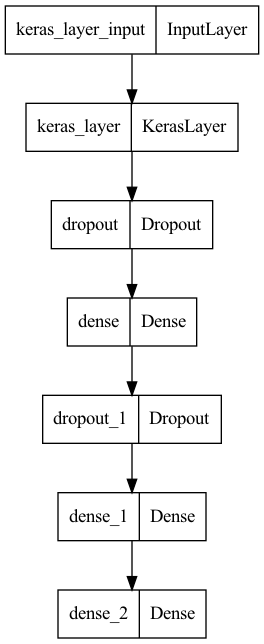

In [16]:
# getting graph of model
plot_model(model)

In [17]:
%%time

history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=64,
                    validation_data=(X_test, y_test),
                    verbose=1,
                    callbacks=[callbacks])

Epoch 1/20


2021-12-13 07:01:02.078307: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - ETA: 0s - loss: 0.3147 - accuracy: 0.9014 - precision: 0.1667 - recall: 0.0101

2021-12-13 07:01:07.715040: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


131/131 [==============================] - 7s 46ms/step - loss: 0.3147 - accuracy: 0.9014 - precision: 0.1667 - recall: 0.0101 - val_loss: 0.3357 - val_accuracy: 0.9045 - val_precision: 0.4932 - val_recall: 0.1809
Epoch 2/20
131/131 [==============================] - 6s 42ms/step - loss: 0.2470 - accuracy: 0.9096 - precision: 0.6022 - recall: 0.1373 - val_loss: 0.2612 - val_accuracy: 0.9040 - val_precision: 0.4886 - val_recall: 0.2161
Epoch 3/20
131/131 [==============================] - 6s 42ms/step - loss: 0.1983 - accuracy: 0.9198 - precision: 0.6533 - recall: 0.3275 - val_loss: 0.2759 - val_accuracy: 0.8782 - val_precision: 0.3750 - val_recall: 0.4221
Epoch 4/20
131/131 [==============================] - 6s 43ms/step - loss: 0.1418 - accuracy: 0.9457 - precision: 0.7868 - recall: 0.5856 - val_loss: 0.2896 - val_accuracy: 0.8887 - val_precision: 0.4190 - val_recall: 0.4422
Epoch 5/20
131/131 [==============================] - 5s 40ms/step - loss: 0.1048 - accuracy: 0.9589 - precisio

In [18]:
model = tf.keras.models.load_model(('pcl_model.h5'),custom_objects={'KerasLayer':hub.KerasLayer})

2021-12-13 07:02:50.213539: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [19]:
score = model.evaluate(X_test, y_test, verbose = 1) 
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])
print('Test precision:', score[2]) 
print('Test recall:', score[3])

 5/66 [=>............................] - ETA: 0s - loss: 1.5367 - accuracy: 0.4437 - precision: 1.0000 - recall: 0.4437 

2021-12-13 07:02:50.773432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


66/66 [==============================] - 1s 11ms/step - loss: 0.2896 - accuracy: 0.8887 - precision: 0.4190 - recall: 0.4422
Test loss: 0.2895835041999817
Test accuracy: 0.8887296915054321
Test precision: 0.41904762387275696
Test recall: 0.4422110617160797


In [20]:
pred = model.predict(X_test) 
# print(pred)
# pred = np.argmax(pred, axis = 1)[:5] 
# label = np.argmax(y_test,axis = 1)[:5] 

# print(pred) 
# print(label)
pos = pred[pred >= 0.5]
neg = pred[pred < 0.5]
print(len(pos), len(neg))

2021-12-13 07:02:51.666083: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


210 1884


In [21]:
# relabel
pred[pred >= 0.5] = 1
pred[pred < 0.5] = 0
pred = pred.astype(int)

In [22]:
# save results to file
labels2file(pred, os.path.join('res/', 'task1.txt'))

In [23]:
# for subtask 1 (we convert our list of labels into a list of lists to make 
# it compatible with the labels2file function)
labels2file(test_set.label.apply(lambda x:[x]).tolist(), os.path.join('ref/', 'task1.txt'))

In [24]:
# Now, we can just call the official scorer, which takes an input_directory and an output_directory
# as arguments. In this example, both will be the root directory of this notebook.
!python3 evaluation.py . .

In [25]:
# The scorer generated a results file called "scores.txt". 
# We can now see the performance of a random baseline on the training set.
!cat scores.txt

task1_precision:0.41904761904761906
task1_recall:0.44221105527638194
task1_f1:0.43031784841075804


In [26]:
# the left pane should now show a file called submission.zip, which you can submit to Codalab
!cp 'res/task1.txt' 'task1.txt'
!zip submission.zip 'task1.txt'
# ! rm 'task1.txt'

updating: task1.txt (deflated 94%)


In [27]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

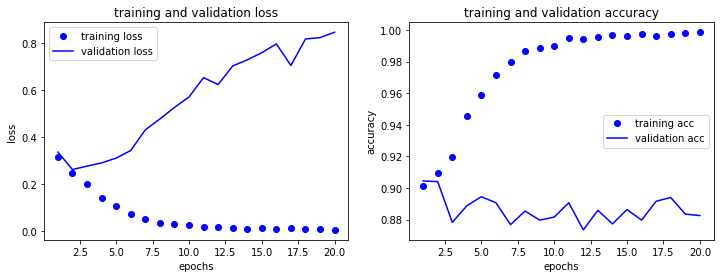

In [28]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
prec = history_dict['precision']
val_prec = history_dict['val_precision']
rec = history_dict['recall']
val_rec = history_dict['val_recall']



epochs = range(1, len(acc) + 1)

plt.rcParams["figure.figsize"] = (12,4)

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo', label='training loss')
plt.plot(epochs, val_loss, 'b', label='validation loss')
plt.title('training and validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'bo', label='training acc')
plt.plot(epochs, val_acc, 'b', label='validation acc')
plt.title('training and validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()

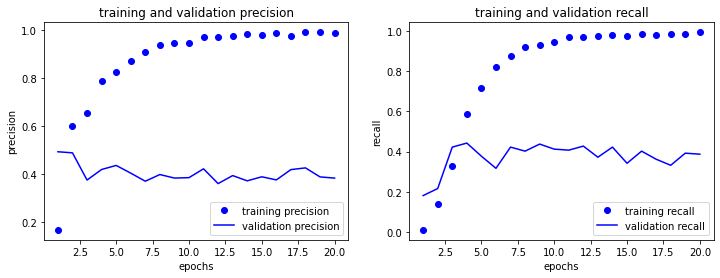

In [29]:
plt.subplot(1, 2, 1)
plt.plot(epochs, prec, 'bo', label='training precision')
plt.plot(epochs, val_prec, 'b', label='validation precision')
plt.title('training and validation precision')
plt.xlabel('epochs')
plt.ylabel('precision')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, rec, 'bo', label='training recall')
plt.plot(epochs, val_rec, 'b', label='validation recall')
plt.title('training and validation recall')
plt.xlabel('epochs')
plt.ylabel('recall')
plt.legend()

plt.show()

In [31]:
# saving model weights
# model.save_weights('f1_0430_consistent.h5')

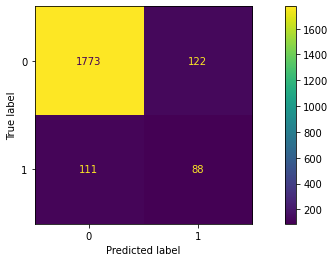

In [33]:
cm = confusion_matrix(test_set.label.to_list(), pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()